In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle,sys,os
import antropy as ant
from numpy import *
import heapq, qnorm
import ruptures as rpt
from scipy.stats import norm, pearsonr, zscore, rankdata, mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.decomposition import PCA
from matplotlib.patches import PathPatch
from statannot import add_stat_annotation
import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 3))

In [2]:
with open('../../Human_hg38_chrom_ends.pkl','rb') as a:
    ENDS = pickle.load(a)

with open('../../Human_hg38_auto_10kb_windows.pkl','rb') as b:
    W = pickle.load(b)

In [3]:
df = pd.read_csv('3202_sequence_index.tsv',sep='\t')
runs = df['RUN_NAME'].tolist()
files = df['LIBRARY_NAME'].tolist()
sorted_files = sorted(files)
batches = [x.split('-')[-2] for x in runs]
bs = unique(batches)
BATCHES = {}
for batch in bs:
    idxs = [i for i in range(len(batches)) if batches[i]==batch]
    samples = array(files)[idxs]
    BATCHES[batch] = list(samples)

In [4]:
def get_numpy_arr(infile,columns=None):
    arr_file = load(infile)
    if columns is None:
        arr = arr_file['arr']
    else:
        arr = arr_file['arr'][:,columns]
    for cols in range(arr.shape[1]):
        csum = sum(arr[:,cols])
        arr[:,cols] /= csum
    return arr

def get_full_table(arr,win=10000):
    rows = 0
    full_table = []
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        full_table.append(arr[rows:rows+windows,:])
        rows += windows
    if rows!=arr.shape[0]:
        print('error')
    return full_table

def get_full_table_array_k_chr(full_table,win=10000,k=1):
    ends = []
    if k == 1:
        for ch in range(22):
            if ch == 0:
                arr = full_table[ch]
            else:
                arr = concatenate((arr,full_table[ch]),axis=0)
            ends.append(arr.shape[0])
    else:
        ft = []
        for ch in range(22):
            chrom = 'chr'+str(ch+1)
            bound = ENDS[chrom]
            win2 = win*k
            windows2 = bound // win2
            arr_i = full_table[ch]
            arr_k = zeros((windows2,arr_i.shape[1]))
            for j in range(windows2-1):
                arr_k[j] = arr_i[j*k:(j+1)*k,:].sum(axis=0)
            arr_k[-1] = arr_i[(windows2-1)*k:,:].sum(axis=0)
            if ch==0:
                arr = arr_k
            else:
                arr = concatenate((arr,arr_k),axis=0)
            ends.append(arr.shape[0])
    return arr, ends

def get_arr(infile,columns=None,k=1):
    df_arr = get_numpy_arr(infile,columns)
    table = get_full_table(df_arr)
    ftk, ends = get_full_table_array_k_chr(table,k=k)
    print(ends)
    return ftk #arrs

In [5]:
k = 1
thgs = get_arr('merged_table_no_correction_1000g_10kb.npz',k=k)
thgs.shape

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]


(287487, 3202)

In [6]:
brcas = get_arr('../../merged_table_no_correction_brca_10kb.npz',k=k)
crcs = get_arr('../../merged_table_no_correction_crc_10kb.npz',k=k)
ctrl29s = get_arr('../../merged_table_no_correction_ctrl29_10kb.npz',k=k)

ctrl38s = get_arr('../../merged_table_no_correction_ctrl38_10kb.npz',k=k)
ctdna36s = get_arr('../../merged_table_no_correction_ctdna36luad_10kb.npz',k=k)

ega8460 = get_arr('../../merged_table_no_correction_EGA8460_10kb.npz',k=k)
ega5343_ctrl = get_arr('../../merged_table_no_correction_EGA5343_ctrl_10kb.npz',k=k)

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 26

In [7]:
ega5343_prostate = get_arr('../../merged_table_no_correction_EGA5343_prostate_10kb.npz',k=k)

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]


In [8]:
arr_file = load('../../merged_table_no_correction_EGA7080_10kb.npz')
samples = arr_file['samples']

ctrl = [i for i in range(len(samples)) if samples[i].startswith('Ctrl')]
ctdna = [i for i in range(len(samples)) if i not in ctrl] # and samples[i].endswith('_1')
ega7080_ctrl = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctrl,k=k)
ega7080_ctdna = get_arr('../../merged_table_no_correction_EGA7080_10kb.npz',columns=ctdna,k=k)

[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
[24895, 49114, 68943, 87964, 106117, 123197, 139131, 153644, 167483, 180862, 194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]


In [9]:
import gzip
nucleosomes = {}
# download at https://generegulation.org/NGS/stable_nucs/hg38/GSE81314_healthy_Song_stable_100bp_hg38.bed.gz
with gzip.open('GSE81314_healthy_Song_stable_100bp_hg38.bed.gz','r') as f:        
    for lines in f:        
        content = lines.decode().strip().split('\t')
        chrom = content[0]
        reg = (content[1],content[2])
        if chrom not in nucleosomes:
            nucleosomes[chrom] = []
        nucleosomes[chrom].append(reg)

allgenes = {}; pcgenes = {}; ncgenes={}; allgene_info = {}; pcgene_info = {}
with open('Allgenes.bed','r') as f:        
    for lines in f:        
        content = lines.strip().split('\t')
        chrom = content[0]
        reg = (content[1],content[2])
        gene = content[3]; coor = chrom+':'+str(reg[0])+'-'+str(reg[1])
        if gene not in allgene_info:
            allgene_info[gene] = []
        allgene_info[gene].append(coor)
        gtype = content[9].split('gene_type=')[1].split(';')[0]
        if gtype == 'protein_coding':
            if chrom not in pcgenes:
                pcgenes[chrom]=[]
            pcgenes[chrom].append(reg)
            if gene not in pcgene_info:
                pcgene_info[gene] = []
            pcgene_info[gene].append(coor)
        else:
            if chrom not in ncgenes:
                ncgenes[chrom]=[]
            ncgenes[chrom].append(reg)
        if chrom not in allgenes:
            allgenes[chrom] = []
        allgenes[chrom].append(reg)

In [10]:
def get_gene_table(genedict,size,win=10000):
    arr = zeros(size)
    offset = 0
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        if chrom not in genedict:
            offset += windows
            continue
        for r in genedict[chrom]:
            start = int(r[0])
            end = int(r[1])
            w1 = start // win
            w2 = end // win
            if offset+w1>size:
                print('error')
                continue
            for j in range(w1,w2+1):
                arr[offset+j]+=1
        offset += windows
    if offset!=size:
        print('unmatched size',size,offset)
    return arr

def get_nucleosome_table(size,win=10000):
    arr = zeros(size)
    offset = 0
    for ch in range(22):
        chrom = 'chr'+str(ch+1)
        bound = ENDS[chrom]
        windows = bound // win
        for r in nucleosomes[chrom]:
            start = int(r[0])
            end = int(r[1])
            w1 = start // win
            w2 = end // win
            if offset+w1>size:
                continue
            if w1 == w2:
                arr[offset+w1]+=1
            else:
                #print(chrom,r)
                arr[offset+w1]+=1;arr[offset+w2]+=1
        offset += windows
    if offset!=size:
        print('unmatched size',size,offset)
    return arr

In [11]:
ends = [24895, 49114, 68943, 87964, 106117, 123197,139131, 153644, 167483, 180862, 
        194370, 207697, 219133, 229837, 240036, 249069, 257394, 265431, 271292, 277736, 282406, 287487]
feats = [i for i in range(thgs.shape[0]) if sum(thgs[i,:])>0]
print(ends[-1]-len(feats))
#zf = [i for i in range(thgs.shape[0]) if i not in feats]
#print(len(zf))
chr_splits = [0]
j = 0
for e in ends:
    for i in range(j,len(feats)):
        if feats[i] > e:
            chr_splits.append(i)
            j = i
            break
chr_splits.append(len(feats))
print(chr_splits)

51248
[0, 21838, 43007, 61151, 77732, 93356, 108799, 122508, 135682, 146854, 158478, 170121, 181337, 190291, 197701, 205137, 211316, 216730, 222093, 226049, 231029, 233445, 236239]


In [12]:
nucleosome = get_nucleosome_table(287487)
allgene = get_gene_table(allgenes,287487)
pcgene = get_gene_table(pcgenes,287487)
ncgene = get_gene_table(ncgenes,287487)
nucleosome = nucleosome[feats]
allgene = allgene[feats]
pcgene = pcgene[feats]
ncgene = ncgene[feats]

In [13]:
allgene_windows = {}
chr_windows = [ENDS['chr'+str(ch+1)]//10000 for ch in range(22)]
offsets = [0]+[sum(chr_windows[:i]) for i in range(1,len(chr_windows)+1)]
for gene in allgene_info:
    coor = allgene_info[gene]
    reg = coor[0]
    chrom = reg.split(':')[0]
    if chrom in ['chrX','chrY','chrM']:
        continue
    ch = int(chrom.split('r')[1]); offset = offsets[ch-1]
    start = offset+int((reg.split(':')[1]).split('-')[0])//10000
    end = offset+int(reg.split('-')[1])//10000
    if start not in feats or end not in feats:
        continue
    allgene_windows[gene]=(feats.index(start),feats.index(end))

In [14]:
def get_rank(arr):
    ranked_arr = []
    for i in range(arr.shape[1]):
        ranked = rankdata(arr[:,i],'min')
        ranked_arr.append(ranked)
    return array(ranked_arr).T

In [15]:
rctrl38s = get_rank(ctrl38s[feats,:])
rctdna36s = get_rank(ctdna36s[feats,:])
rpost22s = get_rank(post22s[feats,:])
rbrcas = get_rank(brcas[feats,:])
rcrcs = get_rank(crcs[feats,:])
rctrl29s = get_rank(ctrl29s[feats,:])
rega5343_ctrl = get_rank(ega5343_ctrl[feats,:])
rega7080_ctrl = get_rank(ega7080_ctrl[feats,:])
rega8460 = get_rank(ega8460[feats,:])
rega7080_ctdna = get_rank(ega7080_ctdna[feats,:])
rega5343_prostate = get_rank(ega5343_prostate[feats,:])
rthgs = get_rank(thgs[feats,:])

In [16]:
# segmentation
def get_breakpoints(arr=rthgs,splits=chr_splits):
    bkps = {}
    breaks = [0]
    offset = 0
    for ch in range(22):
        ctrl_signals = mean(arr[splits[ch]:splits[ch+1],:],axis=1)
        sigma = std(ctrl_signals)
        n = len(ctrl_signals)
        if n < 100:
            offset+=n
            continue
        algo = rpt.Binseg(model="l1",min_size=100).fit(ctrl_signals) # min size is 1Mbp # "l1", "rbf", "linear", "normal", "ar",...
        my_bkps = algo.predict(pen=log(n)*sigma)
        bkps['chr'+str(ch+1)] = [offset]+[x+offset for x in my_bkps]
        breaks += [x+offset for x in my_bkps]
        offset+= n
    return bkps, breaks
bkps, breaks = get_breakpoints()

In [17]:
rctrls = hstack((rctrl29s,rega7080_ctrl,rega5343_ctrl,rctrl38s)); print(rctrls.shape)

(236239, 113)


In [18]:
rctdnas = hstack((rctdna36s,rega7080_ctdna,rega5343_prostate,rbrcas,rcrcs,rega8460)); print(rctdnas.shape)

(236239, 362)


In [19]:
len(breaks)

1091

In [20]:
def segment_miu_var(arr=rctrls,breaks=breaks):
    n = len(breaks)-1
    arr_miu = []; arr_var = []
    for s in range(arr.shape[1]): #s for samples
        arrseg = []
        for i in range(n):
            arr_segment = mean(arr[breaks[i]:breaks[i+1],s])  # segment rank
            arrseg.append(arr_segment)
        arr_miu.append(mean(arrseg)); arr_var.append(var(arrseg))    
    return arr_miu,arr_var

In [21]:
def region_lookup(pos_start,pos_end,wsize=10000,feats=feats,ends=ends):
    pos_end = min(pos_end,len(feats)-1)
    for i,e in enumerate(chr_splits):
        if pos_end <= e:
            ch = 'chr'+str(i)
            if i == 0:
                reg_start = wsize*feats[pos_start]+1
                reg_end = wsize*feats[pos_end]
            else:
                reg_start = wsize*(feats[pos_start]-feats[chr_splits[i-1]])+1
                reg_end = wsize*(feats[pos_end]-feats[chr_splits[i-1]])
            return ch+':'+str(reg_start)+'-'+str(reg_end)

In [22]:
# exclude chr19 due to significant inter-dataset and intra-dataset variation
chr19_start = sum([len(bkps['chr'+str(ch)])-1 for ch in range(1,19)]) 
chr19_end = sum([len(bkps['chr'+str(ch)])-1 for ch in range(1,20)])
print(chr19_start, chr19_end)

1019 1040


In [23]:
def find_over_represented_segment(arr=rctdnas,breaks=breaks,ref=rctrls,topn=20): #breaks=[x for x in breaks if x not in bkps['chr19']]
    n = len(breaks)-1
    rs = []
    for i in range(n):
        ref_median = median(sum(ref[breaks[i]:breaks[i+1],:],axis=0))
        arr_median = median(sum(arr[breaks[i]:breaks[i+1],:],axis=0))
        rs.append(arr_median/ref_median)
    topn_idx = array([i for i in argsort(rs)[::-1][:topn*5] if i not in range(chr19_start, chr19_end+1)][:topn])
    return topn_idx, array(rs)[topn_idx]

In [24]:
# n = 362
topn_idx,ratios = find_over_represented_segment()
topn_idx,ratios

(array([507, 608, 822, 607, 621, 599, 604, 612, 603,  94,  84, 246, 529,
        532, 601,  72, 622, 566, 819, 549]),
 array([1.36682027, 1.34278028, 1.33382665, 1.32229145, 1.31648016,
        1.31001549, 1.29926333, 1.287946  , 1.28156646, 1.26815743,
        1.25805296, 1.25006591, 1.24984435, 1.24945487, 1.246383  ,
        1.23927494, 1.23282875, 1.22986723, 1.2286647 , 1.22739105]))

In [25]:
topn_regions = [region_lookup(breaks[idx],breaks[idx+1]) for idx in topn_idx]
print(sorted(topn_regions))

['chr12:83350001-87750000', 'chr12:90150001-91600000', 'chr1:187440001-191390000', 'chr1:215740001-218290000', 'chr1:240270001-241270000', 'chr3:117700001-118700000', 'chr7:126200001-127200000', 'chr7:153090001-154690000', 'chr7:78250001-79250000', 'chr7:8550001-9550000', 'chr7:88350001-90100000', 'chr8:110160001-114060000', 'chr8:114060001-116210000', 'chr8:68020001-69270000', 'chr8:70670001-73020000', 'chr8:74370001-75520000', 'chr8:75520001-78120000', 'chr8:81820001-82820000', 'chr8:82820001-84520000', 'chr8:91060001-93610000']


In [26]:
def find_under_represented_segment(arr=rctdnas,breaks=breaks,ref=rctrls,topn=20): #breaks=[x for x in breaks if x not in bkps['chr19']]
    n = len(breaks)-1
    rs = []
    for i in range(n):
        ref_median = median(sum(ref[breaks[i]:breaks[i+1],:],axis=0))
        arr_median = median(sum(arr[breaks[i]:breaks[i+1],:],axis=0))
        rs.append(arr_median/ref_median)
    topn_idx = array([i for i in argsort(rs)[:topn*5] if i not in range(chr19_start, chr19_end+1)][:topn])
    return topn_idx, array(rs)[topn_idx]

In [27]:
# n = 362
botn_idx,ratios2 = find_under_represented_segment()
botn_idx,ratios2

(array([ 971,  969, 1089,  968,  927,  741, 1082,  311,  941, 1084, 1083,
         988,  959,  683,    5,  852,  919,   11,    1, 1086]),
 array([0.80572031, 0.82762167, 0.82987974, 0.83673297, 0.85254089,
        0.85392224, 0.85788296, 0.86557545, 0.87276371, 0.87517224,
        0.87684457, 0.87808934, 0.87867759, 0.87892821, 0.87926164,
        0.87952452, 0.88624233, 0.88626529, 0.88823509, 0.88970078]))

In [28]:
botn_regions = [region_lookup(breaks[idx],breaks[idx+1]) for idx in botn_idx]
print(sorted(botn_regions))

['chr11:1-1500000', 'chr13:61040001-72040000', 'chr15:55110001-58060000', 'chr15:75660001-77360000', 'chr16:1-3150000', 'chr16:66790001-70940000', 'chr16:87540001-90370000', 'chr17:1-5630000', 'chr17:7130001-9230000', 'chr17:80830001-83210000', 'chr1:1100001-3780000', 'chr1:21490001-28390000', 'chr1:8730001-12630000', 'chr22:36870001-39520000', 'chr22:39520001-41020000', 'chr22:41020001-43120000', 'chr22:45670001-47020000', 'chr22:49320001-50600000', 'chr4:104560001-106110000', 'chr9:135670001-137320000']


In [29]:
botn = ['chr1:1100001-3780000', 'chr1:8730001-12630000', 'chr1:21490001-28390000', 'chr4:104560001-106110000', 'chr9:135670001-137320000',
        'chr11:1-1500000', 'chr13:61040001-72040000', 'chr15:55110001-58060000', 'chr15:75660001-77360000', 
        'chr16:1-3150000', 'chr16:66790001-70940000', 'chr16:87540001-90370000', 'chr17:1-5630000', 'chr17:7130001-9230000', 'chr17:80830001-83210000',
         'chr22:36870001-43120000','chr22:45670001-47020000','chr22:49320001-50600000']

data = open('top20_ctdna_vs_cfdna_downregulated_regions_median.ucsc.tsv') # browse ucsc table for each segment coordinate and concatenate the output
pipeline = open('top20_ctdna_vs_cfdna_downregulated_regions.tsv','w')
pipeline.write('Segment_Coordinates\tGenes_within_region\n')
i = 0
header = None
genes = []
for lines in data:
    lines = lines.rstrip()
    content = lines.split('\t')
    if header is None:
        header = content
        gene_idx = header.index('name2')
        continue
    if lines.startswith('#'):
        pipeline.write(botn[i]+'\t'+(',').join(list(unique(genes)))+'\n')
        i += 1
        genes = []
    else:
        genes.append(content[gene_idx])
pipeline.write(botn[i]+'\t'+(',').join(list(unique(genes)))+'\n')
pipeline.close()
data.close()

In [30]:
topn = ['chr1:187440001-191390000', 'chr1:215740001-218290000', 'chr1:240270001-241270000',
        'chr3:117700001-118700000', 'chr7:8550001-9550000', 'chr7:78250001-79250000', 'chr7:88350001-90100000',
        'chr7:126200001-127200000', 'chr7:153090001-154690000', 
        'chr8:68020001-69270000', 'chr8:70670001-73020000', 'chr8:74370001-78120000', 
        'chr8:81820001-84520000', 'chr8:91060001-93610000','chr8:110160001-116210000', 
        'chr12:83350001-87750000', 'chr12:90150001-91600000']

data = open('top20_ctdna_vs_cfdna_upregulated_regions_median.ucsc.tsv') # browse ucsc table for each segment coordinate and concatenate the output
pipeline = open('top20_ctdna_vs_cfdna_upregulated_regions.tsv','w')
pipeline.write('Segment_Coordinates\tGenes_within_region\n')
i = 0
header = None
genes = []
for lines in data:
    lines = lines.rstrip()
    content = lines.split('\t')
    if header is None:
        header = content
        gene_idx = header.index('name2')
        continue
    if lines.startswith('#'):
        pipeline.write(topn[i]+'\t'+(',').join(list(unique(genes)))+'\n')
        i += 1
        genes = []
    else:
        genes.append(content[gene_idx])
pipeline.write(topn[i]+'\t'+(',').join(list(unique(genes)))+'\n')
pipeline.close()
data.close()

In [31]:
import matplotlib as mpl
cmap = mpl.colormaps['Spectral_r']
# Take colors at regular intervals spanning the colormap.
colors = cmap(linspace(0, 1, 4))
sns.set_context(context=None, font_scale=1, rc={'legend.fontsize': 5})

def segment_ratio_vs_nucleosome_median(arr=rctrls,breaks=breaks,ref=rthgs):
    n = len(breaks)-1
    rs = [];ns = []; ags = []; pgs = []; ngs = []
    for i in range(n):
        ref_median = median(sum(ref[breaks[i]:breaks[i+1],:],axis=0))
        arr_median = median(sum(arr[breaks[i]:breaks[i+1],:],axis=0))
        nuc_seg = mean(nucleosome[breaks[i]:breaks[i+1]])
        ag_seg = mean(allgene[breaks[i]:breaks[i+1]])
        pg_seg = mean(pcgene[breaks[i]:breaks[i+1]])
        ng_seg = mean(ncgene[breaks[i]:breaks[i+1]])
        ns.append(nuc_seg);ags.append(ag_seg);pgs.append(pg_seg);ngs.append(ng_seg);
        rs.append(arr_median/ref_median)
    return rs,ns,ags,pgs,ngs

def plot_segment_vs_genes_nucleosome2(arr=rctdnas,ref=rctrls,figname=None):
    fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(4, 9)) #5,10
    plt.subplots_adjust(hspace=0.5)
    for ch, ax in zip([1,3,4,7,8,9,11,12,13,15,16,17,22,100], axs.ravel()):
        if ch == 100:
            rs,ns,ags,pgs,ngs = segment_ratio_vs_nucleosome_median(arr=arr,breaks=breaks,ref=ref)
            chrom = 'whole genome'
        else:
            chrom = 'chr'+str(ch)
            rs,ns,ags,pgs,ngs = segment_ratio_vs_nucleosome_median(arr=arr,breaks=bkps[chrom],ref=ref)
        coef_n = round(pearsonr(ns,rs)[0],3); coef_g = round(pearsonr(ags,rs)[0],3)
        #ax.annotate('R='+str(round(r0,3)), (0.1, 0.8), xycoords='axes fraction')
        text = r'$\mathregular{R_n}=$'+str(coef_n)+' '+r'$\mathregular{R_g}=$'+str(coef_g)
        ax.set_title(chrom,fontdict={'fontsize':10},pad=1);ax.annotate(text,(0.1, 0.05), xycoords='axes fraction',fontsize=7)
        ax.tick_params(pad=1)
        if ch == 100:
            sns.lineplot(x=range(len(ns)),y=ns,lw=1,color='grey',alpha=0.5,label='nuc count',ax=ax)
            sns.lineplot(x=range(len(ns)),y=ags,lw=1,color='royalblue',alpha=0.5,label='gene count',ax=ax)
            sns.lineplot(x=range(len(ns)),y=rs,lw=1,color='orange',label='ctDNA/cfDNA',ax=ax)
            continue
        else:
            sns.lineplot(x=range(len(ns)),y=ns,lw=1,color='grey',alpha=0.5,ax=ax)
            sns.lineplot(x=range(len(ns)),y=ags,lw=1,color='royalblue',alpha=0.5,ax=ax)
            sns.lineplot(x=range(len(ns)),y=rs,lw=1,color='orange',ax=ax)
        xs = [];ys = []
        for idx in sorted(topn_idx):
            if breaks[idx] in bkps[chrom][:-1]:
                i = bkps[chrom].index(breaks[idx]);r = rs[i];xs.append(i);ys.append(r)
        sns.scatterplot(x=xs,y=ys,ax=ax,color='C2',s=15); #print(chrom,'up',ys)
        xs = [];ys = []
        for idx in sorted(botn_idx):
            if breaks[idx] in bkps[chrom][:-1]:
                i = bkps[chrom].index(breaks[idx]);r = rs[i];xs.append(i);ys.append(r)
        sns.scatterplot(x=xs,y=ys,ax=ax,color='C3',s=15); #print(chrom,'down',ys)
    plt.legend(loc='upper right')
    if not figname is None:
        fig.savefig(figname,bbox_inches='tight',dpi=150) #

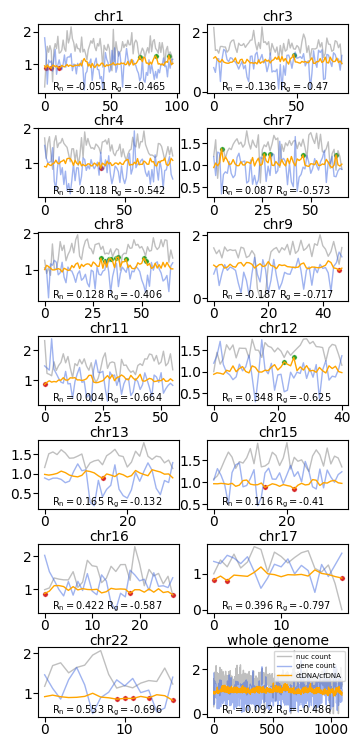

In [32]:
#plot_segment_vs_genes_nucleosome2(figname='new_figures/fig.ctDNA_vs_cfDNA_seg_vs_gene_nuc_lineplot.png')
plot_segment_vs_genes_nucleosome2()

In [33]:
def sort_arr_by_chr_mean(arr,breaks=bkps['chr1']): #chrom='chr1',
    #i = int(chrom.split('hr')[1])-1
    m = mean(arr[breaks[0]:breaks[-1],:],axis=0)
    sorted_idx = argsort(m)
    return sorted_idx

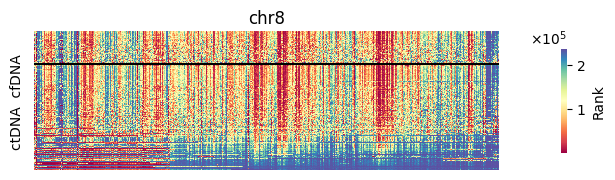

In [34]:
plt.figure(figsize=(8,1.8))
chrom='chr8'
plt.title(chrom)
idx1 = sort_arr_by_chr_mean(rctrls,breaks=breaks[601:621])
idx2 = sort_arr_by_chr_mean(rctdnas,breaks=breaks[601:621])
arr = vstack((rctrls.T[idx1,:],rctdnas.T[idx2,:]))
ch = int(chrom.split('hr')[1])-1
ax = sns.heatmap(arr[:,chr_splits[ch]:chr_splits[ch+1]],cbar_kws = dict(label='Rank',location="right",pad=0.1,shrink=.75,format=formatter),robust=True,
                 cmap="Spectral",vmin=1,vmax=236239)
ax.tick_params(left=False,bottom=False,pad=0,labelsize=8);ax.set(ylabel='ctDNA  cfDNA',xticklabels=[],yticklabels=[])
ax.hlines([rctrls.shape[1]], *ax.get_xlim(),colors='black')
plt.show()
#ax.vlines([x-bkps[chrom][0] for x in bkps[chrom]],colors='black',linestyles='dashed',*ax.get_ylim())
#plt.savefig('new_figures/fig.chr8-heatmap.png',bbox_inches='tight',dpi=120)

In [35]:
def find_over_represented_segment2(arr=rctdnas,breaks=breaks,ref=rctrls,thres=1.1):
    n = len(breaks)-1
    rs = []
    for i in range(n):
        ref_median = median(sum(ref[breaks[i]:breaks[i+1],:],axis=0))
        ratios = []
        for s in range(arr.shape[1]):
            segment = sum(arr[breaks[i]:breaks[i+1],s])
            ratio = segment/ref_median
            ratios.append(ratio)
        rs.append(median(ratios))
    pass_idx = [i for i in range(len(rs)) if rs[i]>thres and i not in range(chr19_start, chr19_end+1)] 
    return pass_idx, array(rs)[pass_idx]

def find_under_represented_segment2(arr=rctdnas,breaks=breaks,ref=rctrls,thres=1/1.1):
    n = len(breaks)-1
    rs = []
    for i in range(n):
        ref_median = median(sum(ref[breaks[i]:breaks[i+1],:],axis=0))
        ratios = []
        for s in range(arr.shape[1]):
            segment = sum(arr[breaks[i]:breaks[i+1],s])
            ratio = segment/ref_median
            ratios.append(ratio)
        rs.append(median(ratios))
    pass_idx = [i for i in range(len(rs)) if rs[i]<thres and i not in range(chr19_start, chr19_end+1)] 
    return pass_idx, array(rs)[pass_idx]

In [36]:
topn_idx7080,tratios7080 = find_over_represented_segment2(arr=rega7080_ctdna,ref=rega7080_ctrl) # size of matched-control (n=22) too small; replaced with all controls (n=113)
botn_idx7080,bratios7080 = find_under_represented_segment2(arr=rega7080_ctdna,ref=rega7080_ctrl) 

topn_idx36,tratios36 = find_over_represented_segment2(arr=rctdna36s,ref=rctrl38s)
botn_idx36,bratios36 = find_under_represented_segment2(arr=rctdna36s,ref=rctrl38s)

topn_idx8460,tratios8460 = find_over_represented_segment2(arr=rega8460,ref=rctrls)
botn_idx8460,bratios8460 = find_under_represented_segment2(arr=rega8460,ref=rctrls)

topn_idxbrcas,tratiosbrcas = find_over_represented_segment2(arr=rbrcas,ref=rctrls)
botn_idxbrcas,bratiosbrcas = find_under_represented_segment2(arr=rbrcas,ref=rctrls)

topn_idxcrcs,tratioscrcs = find_over_represented_segment2(arr=rcrcs,ref=rctrls)
botn_idxcrcs,bratioscrcs = find_under_represented_segment2(arr=rcrcs,ref=rctrls)

intersect_top = set(topn_idx7080).intersection(topn_idx36).intersection(topn_idx8460).intersection(topn_idxbrcas).intersection(topn_idxcrcs)
intersect_bot = set(botn_idx7080).intersection(botn_idx36).intersection(botn_idx8460).intersection(botn_idxbrcas).intersection(botn_idxcrcs)

In [37]:
print(intersect_top);print(intersect_bot)

{608, 477, 246}
set()


In [38]:
print(region_lookup(breaks[246],breaks[247]-1),region_lookup(breaks[477],breaks[478]-1),region_lookup(breaks[608],breaks[609]-1))

chr3:117700001-118690000 chr6:114290001-115580000 chr8:82820001-84510000


In [39]:
freqn = ['chr3:117700001-118690000', 'chr6:114290001-115580000', 'chr8:82820001-84510000']

data = open('ctDNA-vs-cfDNA-frequently-over-represented-regions.ucsc.tsv') # browse ucsc table for each segment coordinate and concatenate the output
pipeline = open('ctDNA-vs-cfDNA-frequently-upregulated-regions.tsv','w')
pipeline.write('Coordinates\tGenes_within_region\n')
i = 0
header = None
genes = []
for lines in data:
    lines = lines.rstrip()
    content = lines.split('\t')
    if header is None:
        header = content
        gene_idx = header.index('name2')
        continue
    if lines.startswith('#'):
        pipeline.write(freqn[i]+'\t'+(',').join(list(unique(genes)))+'\n')
        i += 1
        genes = []
    else:
        genes.append(content[gene_idx])
pipeline.write(freqn[i]+'\t'+(',').join(list(unique(genes)))+'\n')
pipeline.close()
data.close()

In [40]:
data = {'group':[],'Cov':[],'type':[]}
total_thg = []; total_ctrl38s = []; total_luad = []; total_sarcoma = []; total_ctrl22 = []; total_ega8460 = []
total_ctrl = []; total_brca = []; total_crc = []
for seg in sorted(list(intersect_top)):
    r = region_lookup(breaks[seg],breaks[seg+1]-1)
    cov_thg = mean(rthgs[breaks[seg]:breaks[seg+1]-1,:],axis=0); total_thg.append(cov_thg)
    cov_ctrl38s = mean(rctrl38s[breaks[seg]:breaks[seg+1]-1,:],axis=0); total_ctrl38s.append(cov_ctrl38s)
    cov_luad = mean(rctdna36s[breaks[seg]:breaks[seg+1]-1,:],axis=0); total_luad.append(cov_luad)
    cov_sarcoma = mean(rega7080_ctdna[breaks[seg]:breaks[seg+1]-1,:],axis=0); total_sarcoma.append(cov_sarcoma)
    cov_ctrl22 = mean(rega7080_ctrl[breaks[seg]:breaks[seg+1]-1,:],axis=0); total_ctrl22.append(cov_ctrl22)
    cov_prostate = mean(rega8460[breaks[seg]:breaks[seg+1]-1,:],axis=0); total_ega8460.append(cov_prostate)
    cov_ctrl = mean(rctrls[breaks[seg]:breaks[seg+1]-1,:],axis=0); total_ctrl.append(cov_ctrl)
    cov_brca = mean(rbrcas[breaks[seg]:breaks[seg+1]-1,:],axis=0); total_brca.append(cov_brca)
    cov_crc = mean(rcrcs[breaks[seg]:breaks[seg+1]-1,:],axis=0); total_crc.append(cov_crc)

total_thg = mean(array(total_thg),axis=0)
total_ctrl38s = mean(array(total_ctrl38s),axis=0)
total_luad = mean(array(total_luad),axis=0)
total_sarcoma = mean(array(total_sarcoma),axis=0)
total_ctrl22 = mean(array(total_ctrl22),axis=0)
total_ega8460 = mean(array(total_ega8460),axis=0)
total_ctrl = mean(array(total_ctrl),axis=0)
total_brca = mean(array(total_brca),axis=0)
total_crc = mean(array(total_crc),axis=0)

u1,p1 = mannwhitneyu(total_ega8460,total_ctrl)
u2,p2 = mannwhitneyu(total_brca,total_ctrl)
u3,p3 = mannwhitneyu(total_crc,total_ctrl)
u4,p4 = mannwhitneyu(total_sarcoma,total_ctrl22)
u5,p5 = mannwhitneyu(total_luad,total_ctrl38s)
ps = [p1,p2,p3,p4,p5]

data['group']+=['late Prostate']*len(total_thg)
data['Cov']+=list(total_thg)
data['type']+=['gDNA']*len(total_thg)
data['group']+=['late Prostate']*len(total_ctrl)
data['Cov']+=list(total_ctrl)
data['type']+=['cfDNA']*len(total_ctrl)
data['group']+=['late Prostate']*len(total_ega8460)
data['Cov']+=list(total_ega8460)
data['type']+=['ctDNA']*len(total_ega8460)

data['group']+=['late BRCA']*len(total_thg)
data['Cov']+=list(total_thg)
data['type']+=['gDNA']*len(total_thg)
data['group']+=['late BRCA']*len(total_ctrl)
data['Cov']+=list(total_ctrl)
data['type']+=['cfDNA']*len(total_ctrl)
data['group']+=['late BRCA']*len(total_brca)
data['Cov']+=list(total_brca)
data['type']+=['ctDNA']*len(total_brca)

data['group']+=['late CRC']*len(total_thg)
data['Cov']+=list(total_thg)
data['type']+=['gDNA']*len(total_thg)
data['group']+=['late CRC']*len(total_ctrl)
data['Cov']+=list(total_ctrl)
data['type']+=['cfDNA']*len(total_ctrl)
data['group']+=['late CRC']*len(total_crc)
data['Cov']+=list(total_crc)
data['type']+=['ctDNA']*len(total_crc)

data['group']+=['pediatric sarcoma']*len(total_thg)
data['Cov']+=list(total_thg)
data['type']+=['gDNA']*len(total_thg)
data['group']+=['pediatric sarcoma']*len(total_ctrl22)
data['Cov']+=list(total_ctrl22)
data['type']+=['cfDNA']*len(total_ctrl22)
data['group']+=['pediatric sarcoma']*len(total_sarcoma)
data['Cov']+=list(total_sarcoma)
data['type']+=['ctDNA']*len(total_sarcoma)

data['group']+=['early LUAD']*len(total_thg)
data['Cov']+=list(total_thg)
data['type']+=['gDNA']*len(total_thg)
data['group']+=['early LUAD']*len(total_ctrl)
data['Cov']+=list(total_ctrl)
data['type']+=['cfDNA']*len(total_ctrl)
data['group']+=['early LUAD']*len(total_luad)
data['Cov']+=list(total_luad)
data['type']+=['ctDNA']*len(total_luad)

In [41]:
len(total_thg)

3202

In [42]:
cmap = mpl.colormaps['Spectral']
cmapr = mpl.colormaps['Spectral_r']
# Take colors at regular intervals spanning the colormap.
colors = cmap(linspace(0, 1, 13))
colors_r = cmapr(linspace(0, 1, 13)) #mpl.colors.rgb2hex(c)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

late BRCA_cfDNA v.s. late BRCA_ctDNA: Custom statistical test, P_val:8.722e-06
late CRC_cfDNA v.s. late CRC_ctDNA: Custom statistical test, P_val:2.443e-08
pediatric sarcoma_cfDNA v.s. pediatric sarcoma_ctDNA: Custom statistical test, P_val:1.643e-05
early LUAD_cfDNA v.s. early LUAD_ctDNA: Custom statistical test, P_val:1.458e-01
late Prostate_cfDNA v.s. late Prostate_ctDNA: Custom statistical test, P_val:3.139e-21


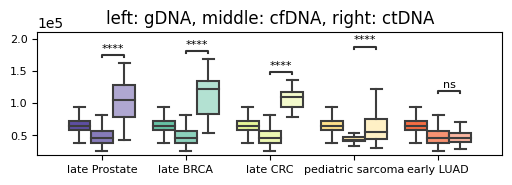

In [43]:
fig, ax = plt.subplots(figsize=(6, 1.6))
hue_order = ['gDNA', 'cfDNA', 'ctDNA']
#colors = ['violet','royalblue','orangered','forestgreen','sienna','gold','navy','violet','royalblue','orangered','forestgreen','sienna','gold']
sns.boxplot(data=data, x="group", y="Cov",hue="type",showfliers = False, hue_order=hue_order, ax=ax)
colors_r = cmapr(linspace(0, 1, 6))
box_colors = [f + (1 - f) * array(mpl.colors.to_rgb(c)) for c in colors_r for f in linspace(0, 0.5, len(hue_order))]
box_patches = [p for p in ax.patches if isinstance(p, PathPatch)]
for patch, color in zip(box_patches, box_colors):
    patch.set_facecolor(color)
ax.get_legend().remove(); ax.set_title('left: gDNA, middle: cfDNA, right: ctDNA')
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,3));ax.tick_params(labelsize=8)
box_pairs=[
    (("late Prostate", "cfDNA"), ("late Prostate", "ctDNA")),(("late BRCA", "cfDNA"), ("late BRCA", "ctDNA")),
    (("late CRC", "cfDNA"), ("late CRC", "ctDNA")),
    (("pediatric sarcoma", "cfDNA"), ("pediatric sarcoma", "ctDNA")),
    (("early LUAD", "cfDNA"), ("early LUAD", "ctDNA")),#(("transposons", "cfDNA"), ("transposons", "ctDNA")),(("CREs", "cfDNA"), ("CREs", "ctDNA")),
    ]
add_stat_annotation(ax,data=data,x="group", y="Cov",hue="type",box_pairs=box_pairs,
                    perform_stat_test=False,pvalues=ps,text_format='star',loc='inside', fontsize=8,verbose=1)
plt.show()
#plt.savefig('new_figures/fig.five_datasets_freq3.png',bbox_inches='tight',dpi=120)

In [44]:
import math

In [48]:
allgene_ratios = {}; allgene_pvals = {}; counted_window = []
var_cutoff = percentile(var(rctrls,axis=1),90)
total_count = 0
for gene in allgene_windows:
    start,end = allgene_windows[gene][0],allgene_windows[gene][1]
    if (start,end) in counted_window:
        continue
    if start==end:
        gene_ctdna = rctdnas[start,:]
        gene_cfdna = rctrls[start,:]  
    else:
        gene_ctdna = mean(rctdnas[start:end+1,:],axis=0)
        gene_cfdna = mean(rctrls[start:end+1,:],axis=0)
    cfdna_var = var(gene_cfdna)
    if min(mean(gene_ctdna),mean(gene_cfdna)) <= 0.1*236239 or cfdna_var >= var_cutoff: # filter low count genes and highly variable genes
        continue
    total_count+=1
    counted_window.append((start,end))
    U, p = mannwhitneyu(gene_ctdna, gene_cfdna)
    ratio = math.log2(mean(gene_ctdna)/mean(gene_cfdna)); #print(gene,ratio)
    allgene_ratios[gene] = ratio; allgene_pvals[gene] = p
print('no. of genes analyzed:',total_count)
ps = []
for gene in allgene_pvals:
    ps.append(allgene_pvals[gene])
adjusted_ps = multipletests(ps,method='bonferroni')
j = 0
for gene in allgene_pvals:
    allgene_pvals[gene] = adjusted_ps[1][j]
    j+=1

no. of genes analyzed: 39001


In [49]:
for gene in allgene_pvals:
    if allgene_pvals[gene] > 0.01 or abs(allgene_ratios[gene])<0.5: # FDR<=0.01 and abs(log2FC)>=0.5
        allgene_ratios.pop(gene)
print('no. of differentially covered genes:',len(allgene_ratios))

no. of differentially covered genes: 797


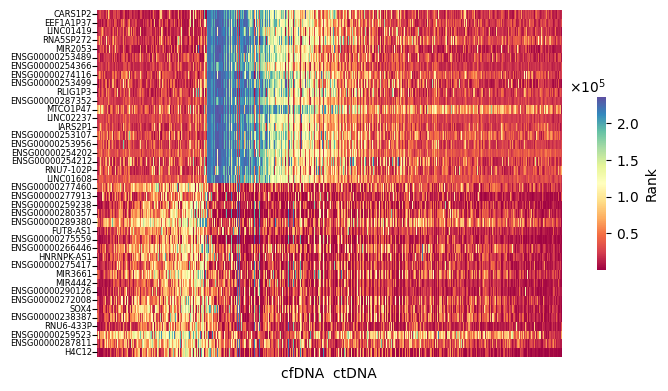

In [52]:
top20_up_gene = heapq.nlargest(20,allgene_ratios,key=allgene_ratios.get)
top20_down_gene = heapq.nsmallest(20,allgene_ratios,key=allgene_ratios.get)

fig, ax = plt.subplots(figsize=(7.6, 4.5))
all40 = top20_up_gene+top20_down_gene
arr_rctdna = []; arr_rcfdna = []
for gene in all40:
    start,end = allgene_windows[gene][0],allgene_windows[gene][1]
    if start==end:
        rctdna_gene = rctdnas[start,:]
        rcfdna_gene = rctrls[start,:]
    else:
        rctdna_gene = mean(rctdnas[start:end+1,:],axis=0)
        rcfdna_gene = mean(rctrls[start:end+1,:],axis=0)
    arr_rctdna.append(list(rctdna_gene))
    arr_rcfdna.append(list(rcfdna_gene))
arr_rctdna = array(arr_rctdna); arr_rcfdna = array(arr_rcfdna)
m1 = mean(arr_rctdna,axis=0)
idx1 = argsort(m1)[::-1]
m2 = mean(arr_rcfdna,axis=0)
idx2 = argsort(m2)
arr_gene = hstack((arr_rcfdna[:,idx2],arr_rctdna[:,idx1]))
ax = sns.heatmap(arr_gene,cbar_kws = dict(label='Rank',location="right",pad=0.06,shrink=0.5,format=formatter),
                 robust=True,cmap="Spectral",vmin=1,vmax=236239)
ax.tick_params(bottom=False,pad=0,labelsize=8);ax.set(xlabel='cfDNA  ctDNA',xticklabels=[])
ax.set_yticks([x+0.5 for x in range(40)], labels=all40,rotation = 0, fontsize=6)
plt.show()
#fig.savefig('new_figures/fig.all40heatmap.filtered.png',bbox_inches='tight',dpi=120)

In [53]:
upgenes = []; downgenes = []
for gene in allgene_ratios:
    r = allgene_ratios[gene]
    if r>0:
        upgenes.append(gene)
    else:
        downgenes.append(gene)

pipeline = open('sig_diff_cov_genes_ctDNA_vs_cfDNA.tsv','w')
pipeline.write('Gene\tlog2FC\tFDR\n')
for gene in upgenes:
    pipeline.write(gene+'\t'+str(allgene_ratios[gene])+'\t'+str(allgene_pvals[gene])+'\n')
for gene in downgenes:
    pipeline.write(gene+'\t'+str(allgene_ratios[gene])+'\t'+str(allgene_pvals[gene])+'\n')
pipeline.close()

In [54]:
def window_ratio_median(idxs,arr=rctdnas,ref=rthgs):
    rs = []
    for i in idxs:
        ref_median = median(ref[i,:],axis=0)
        arr_median = median(arr[i,:],axis=0)
        ratio = arr_median/ref_median
        rs.append(ratio)
    return rs

In [55]:
genic = [i for i in range(len(allgene)) if allgene[i]>0]
intergenic = [i for i in range(len(allgene)) if allgene[i]==0]
pcgenic = [i for i in range(len(allgene)) if pcgene[i]>0]
ncgenic = [i for i in range(len(allgene)) if pcgene[i]==0 and ncgene[i]>0]
nucl = [i for i in range(len(allgene)) if nucleosome[i]>0]
non_nucl = [i for i in range(len(allgene)) if nucleosome[i]==0]
gDNA_intergenic_mean = mean(rthgs[intergenic,:],axis=0)
cfDNA_intergenic_mean = mean(rctrls[intergenic,:],axis=0)
ctDNA_intergenic_mean = mean(rctdnas[intergenic,:],axis=0)
gDNA_genic_mean = mean(rthgs[genic,:],axis=0)
cfDNA_genic_mean = mean(rctrls[genic,:],axis=0)
ctDNA_genic_mean = mean(rctdnas[genic,:],axis=0)

gDNA_pcgenic_mean = mean(rthgs[pcgenic,:],axis=0)
cfDNA_pcgenic_mean = mean(rctrls[pcgenic,:],axis=0)
ctDNA_pcgenic_mean = mean(rctdnas[pcgenic,:],axis=0)
gDNA_ncgenic_mean = mean(rthgs[ncgenic,:],axis=0)
cfDNA_ncgenic_mean = mean(rctrls[ncgenic,:],axis=0)
ctDNA_ncgenic_mean = mean(rctdnas[ncgenic,:],axis=0)

gDNA_nucl_mean = mean(rthgs[nucl,:],axis=0)
cfDNA_nucl_mean = mean(rctrls[nucl,:],axis=0)
ctDNA_nucl_mean = mean(rctdnas[nucl,:],axis=0)
gDNA_non_nucl_mean = mean(rthgs[non_nucl,:],axis=0)
cfDNA_non_nucl_mean = mean(rctrls[non_nucl,:],axis=0)
ctDNA_non_nucl_mean = mean(rctdnas[non_nucl,:],axis=0)

In [56]:
data = {'group':[],'Cov':[],'type':[]}

u1,p1 = mannwhitneyu(cfDNA_nucl_mean,ctDNA_nucl_mean)
u2,p2 = mannwhitneyu(cfDNA_non_nucl_mean,ctDNA_non_nucl_mean)
u3,p3 = mannwhitneyu(cfDNA_genic_mean,ctDNA_genic_mean)
u4,p4 = mannwhitneyu(cfDNA_intergenic_mean,ctDNA_intergenic_mean)
u5,p5 = mannwhitneyu(cfDNA_pcgenic_mean,ctDNA_pcgenic_mean)
u6,p6 = mannwhitneyu(cfDNA_ncgenic_mean,ctDNA_ncgenic_mean)
ps = [p1,p2,p3,p4,p5,p6]

data['group']+=['nuc+']*len(gDNA_nucl_mean)
data['Cov']+=list(gDNA_nucl_mean)
data['type']+=['gDNA']*len(gDNA_nucl_mean)
data['group']+=['nuc+']*len(cfDNA_nucl_mean)
data['Cov']+=list(cfDNA_nucl_mean)
data['type']+=['cfDNA']*len(cfDNA_nucl_mean)
data['group']+=['nuc+']*len(ctDNA_nucl_mean)
data['Cov']+=list(ctDNA_nucl_mean)
data['type']+=['ctDNA']*len(ctDNA_nucl_mean)
data['group']+=['nuc-']*len(gDNA_non_nucl_mean)
data['Cov']+=list(gDNA_non_nucl_mean)
data['type']+=['gDNA']*len(gDNA_non_nucl_mean)
data['group']+=['nuc-']*len(cfDNA_non_nucl_mean)
data['Cov']+=list(cfDNA_non_nucl_mean)
data['type']+=['cfDNA']*len(cfDNA_non_nucl_mean)
data['group']+=['nuc-']*len(ctDNA_non_nucl_mean)
data['Cov']+=list(ctDNA_non_nucl_mean)
data['type']+=['ctDNA']*len(ctDNA_non_nucl_mean)

data['group']+=['genic']*len(gDNA_genic_mean)
data['Cov']+=list(gDNA_genic_mean)
data['type']+=['gDNA']*len(gDNA_genic_mean)
data['group']+=['genic']*len(cfDNA_genic_mean)
data['Cov']+=list(cfDNA_genic_mean)
data['type']+=['cfDNA']*len(cfDNA_genic_mean)
data['group']+=['genic']*len(ctDNA_genic_mean)
data['Cov']+=list(ctDNA_genic_mean)
data['type']+=['ctDNA']*len(ctDNA_genic_mean)
data['group']+=['intergenic']*len(gDNA_intergenic_mean)
data['Cov']+=list(gDNA_intergenic_mean)
data['type']+=['gDNA']*len(gDNA_intergenic_mean)
data['group']+=['intergenic']*len(cfDNA_intergenic_mean)
data['Cov']+=list(cfDNA_intergenic_mean)
data['type']+=['cfDNA']*len(cfDNA_intergenic_mean)
data['group']+=['intergenic']*len(ctDNA_intergenic_mean)
data['Cov']+=list(ctDNA_intergenic_mean)
data['type']+=['ctDNA']*len(ctDNA_intergenic_mean)

data['group']+=['pcgene']*len(gDNA_pcgenic_mean)
data['Cov']+=list(gDNA_pcgenic_mean)
data['type']+=['gDNA']*len(gDNA_pcgenic_mean)
data['group']+=['pcgene']*len(cfDNA_pcgenic_mean)
data['Cov']+=list(cfDNA_pcgenic_mean)
data['type']+=['cfDNA']*len(cfDNA_pcgenic_mean)
data['group']+=['pcgene']*len(ctDNA_pcgenic_mean)
data['Cov']+=list(ctDNA_pcgenic_mean)
data['type']+=['ctDNA']*len(ctDNA_pcgenic_mean)
data['group']+=['ncgene']*len(gDNA_ncgenic_mean)
data['Cov']+=list(gDNA_ncgenic_mean)
data['type']+=['gDNA']*len(gDNA_ncgenic_mean)
data['group']+=['ncgene']*len(cfDNA_ncgenic_mean)
data['Cov']+=list(cfDNA_ncgenic_mean)
data['type']+=['cfDNA']*len(cfDNA_ncgenic_mean)
data['group']+=['ncgene']*len(ctDNA_ncgenic_mean)
data['Cov']+=list(ctDNA_ncgenic_mean)
data['type']+=['ctDNA']*len(ctDNA_ncgenic_mean)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

nuc-_cfDNA v.s. nuc-_ctDNA: Custom statistical test, P_val:2.879e-03
genic_cfDNA v.s. genic_ctDNA: Custom statistical test, P_val:8.476e-12
intergenic_cfDNA v.s. intergenic_ctDNA: Custom statistical test, P_val:7.596e-12
pcgene_cfDNA v.s. pcgene_ctDNA: Custom statistical test, P_val:1.163e-12
ncgene_cfDNA v.s. ncgene_ctDNA: Custom statistical test, P_val:1.642e-13
nuc+_cfDNA v.s. nuc+_ctDNA: Custom statistical test, P_val:2.590e-03


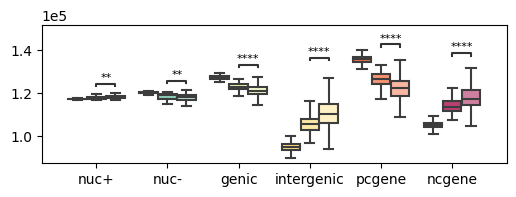

In [57]:
fig, ax = plt.subplots(figsize=(6, 1.8))
hue_order = ['gDNA', 'cfDNA', 'ctDNA']
#colors = ['violet','royalblue','orangered','forestgreen','sienna','gold','navy','violet','royalblue','orangered','forestgreen','sienna','gold']
sns.boxplot(data=data, x="group", y="Cov",hue="type",showfliers = False, hue_order=hue_order, ax=ax)
colors_r = cmapr(linspace(0, 1, 6))
box_colors = [f + (1 - f) * array(mpl.colors.to_rgb(c)) for c in colors_r for f in linspace(0, 0.5, len(hue_order))]
box_patches = [p for p in ax.patches if isinstance(p, PathPatch)]
for patch, color in zip(box_patches, box_colors):
    patch.set_facecolor(color)
ax.get_legend().remove()
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,3))
box_pairs=[
    (("nuc+", "cfDNA"), ("nuc+", "ctDNA")),(("nuc-", "cfDNA"), ("nuc-", "ctDNA")),
    (("genic", "cfDNA"), ("genic", "ctDNA")),(("intergenic", "cfDNA"), ("intergenic", "ctDNA")),
    (("pcgene", "cfDNA"), ("pcgene", "ctDNA")),(("ncgene", "cfDNA"), ("ncgene", "ctDNA")),
    ]
add_stat_annotation(ax,data=data,x="group", y="Cov",hue="type",box_pairs=box_pairs,
                    perform_stat_test=False,pvalues=ps,text_format='star',loc='inside', fontsize=8,verbose=1)
plt.show()
#plt.savefig('new_figures/fig.gDNA-vs-cfDNA-vs-ctDNA-boxplot.png',bbox_inches='tight',dpi=120)

In [104]:
def segment_gene_density(segment_idxs=range(len(breaks)-1)):
    gene_density = []; pcgene_density = []; ncgene_density = []
    for i in segment_idxs:
        seg_legnth = breaks[i+1]-breaks[i]
        ag = sum(allgene[breaks[i]:breaks[i+1]])/seg_legnth; gene_density.append(ag)
        pcg = sum(pcgene[breaks[i]:breaks[i+1]])/seg_legnth; pcgene_density.append(pcg)
        ncg = sum(ncgene[breaks[i]:breaks[i+1]])/seg_legnth; ncgene_density.append(ncg)
    return gene_density, pcgene_density, ncgene_density

In [105]:
gene_density, pcgene_density, ncgene_density = segment_gene_density()

In [106]:
mean(gene_density), mean(pcgene_density), mean(ncgene_density)

(0.9375827133096437, 0.5586099965487689, 0.3789727167608749)

In [107]:
top20up_gene_density, top20up_pcgene_density, top20up_ncgene_density = segment_gene_density(topn_idx)

In [108]:
mean(top20up_gene_density), mean(top20up_pcgene_density), mean(top20up_ncgene_density)

(0.7792391740116021, 0.368574153457931, 0.4106650205536712)

In [109]:
top20down_gene_density, top20down_pcgene_density, top20down_ncgene_density = segment_gene_density(botn_idx)

In [110]:
mean(top20down_gene_density), mean(top20down_pcgene_density), mean(top20down_ncgene_density)

(1.3162822124218825, 0.9279243470957554, 0.38835786532612715)

In [111]:
data = {'density':[],'value':[],'subject':[]}
data['value']+=gene_density
data['density']+=['gene density']*len(gene_density)
data['subject']+=['All']*len(gene_density)
data['value']+=pcgene_density
data['density']+=['pcgene density']*len(pcgene_density)
data['subject']+=['All']*len(pcgene_density)
data['value']+=ncgene_density
data['density']+=['ncgene density']*len(ncgene_density)
data['subject']+=['All']*len(ncgene_density)

u1,p1 = mannwhitneyu(top20up_gene_density,top20down_gene_density)
u2,p2 = mannwhitneyu(top20up_pcgene_density,top20down_pcgene_density)
u3,p3 = mannwhitneyu(top20up_ncgene_density,top20down_ncgene_density)

ps = [p1,p2,p3]

data['value']+=top20up_gene_density
data['density']+=['gene density']*len(top20up_gene_density)
data['subject']+=['Top20up']*len(top20up_gene_density)
data['value']+=top20up_pcgene_density
data['density']+=['pcgene density']*len(top20up_pcgene_density)
data['subject']+=['Top20up']*len(top20up_pcgene_density)
data['value']+=top20up_ncgene_density
data['density']+=['ncgene density']*len(top20up_ncgene_density)
data['subject']+=['Top20up']*len(top20up_ncgene_density)

data['value']+=top20down_gene_density
data['density']+=['gene density']*len(top20down_gene_density)
data['subject']+=['Top20down']*len(top20down_gene_density)
data['value']+=top20down_pcgene_density
data['density']+=['pcgene density']*len(top20down_pcgene_density)
data['subject']+=['Top20down']*len(top20down_pcgene_density)
data['value']+=top20down_ncgene_density
data['density']+=['ncgene density']*len(top20down_ncgene_density)
data['subject']+=['Top20down']*len(top20down_ncgene_density)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pcgene density_Top20up v.s. pcgene density_Top20down: Custom statistical test, P_val:6.667e-06
ncgene density_Top20up v.s. ncgene density_Top20down: Custom statistical test, P_val:3.867e-01
gene density_Top20up v.s. gene density_Top20down: Custom statistical test, P_val:3.499e-06


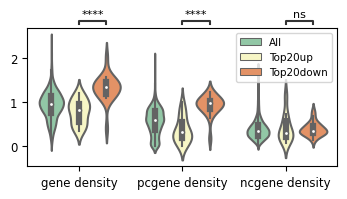

In [117]:
sns.set_context(context=None, font_scale=1, rc={'legend.fontsize': 7.5, 'font.size': 8.5})
fig, ax = plt.subplots(figsize=(4, 1.8))
hue_order = ['All', 'Top20up', 'Top20down']
colors = ['royalblue','orangered','forestgreen']#,'sienna','gold','navy','violet','royalblue','orangered','forestgreen','sienna','gold']
sns.violinplot(data=data, x="density", y="value",hue="subject",showfliers = False, hue_order=hue_order,palette="Spectral_r", ax=ax)
box_pairs=[
    (("gene density", "Top20up"), ("gene density", "Top20down")),(("pcgene density", "Top20up"), ("pcgene density", "Top20down")),
    (("ncgene density", "Top20up"), ("ncgene density", "Top20down")),
    ]
add_stat_annotation(ax,data=data,x="density", y="value",hue="subject",box_pairs=box_pairs,
                    perform_stat_test=False,pvalues=ps,text_format='star',loc='outside', fontsize=8,verbose=1)
plt.show()
#plt.savefig('new_figures/fig.top20up_vs_down_gene_density.png',bbox_inches='tight',dpi=120)